In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.metrics  import precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib as mpl
import numpy as np
np.random.seed(42)


import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#functions
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc='center right', frameon=False)
    plt.xlabel('Threshold', fontsize=14)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('FPR', fontsize=14)
    plt.xlabel('TPR', fontsize=14)



In [3]:
#Without "as_frame" turned to false, it will bring a pandas frame instead of a numpy array, therefore
#it will be harder to address individual elements (panda element is acessed with iloc)
mnist = fetch_openml('mnist_784', version=1, as_frame= False )
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X= mnist["data"]
y = mnist["target"]

In [5]:
#datasets loaded with scikit learn have a row per instance and each row has a column foreach feature,
# in this case, there are 70k pictures and each has 784 features (28x28 pixels)
X.shape


(70000, 784)

(-0.5, 27.5, 27.5, -0.5)

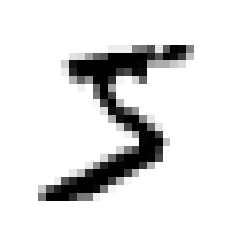

In [6]:
some_digit = X[0] 
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [7]:
y = y.astype(np.uint8)

In [8]:
#scikit learn datasets is already shuffled, easy to collect tests and train datasets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)


SGDClassifier()

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
#Strafied k-fold, performs k cross-validations (remember than in a k-fold cross-validation, a dataset is 
# trained with k-1 subsets and evaluated with 1 dataset, for k times)
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    predicted = clone_clf.predict(X_test_folds)
    correct_pred =  sum(predicted == y_test_folds)
    result = correct_pred/len(y_test_folds)
    print(result)
    
    


0.9612
0.95095
0.9621


In [13]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.97005, 0.97015, 0.9581 ])

In [14]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


 Accuracy is *generally* terrible for classification problems (for instance: we could have a predictor that says \
 that every number is not 5, it would be accurate about 9/10 of times...)
 Therefore there must be a better way: confusion matrix. Such matrix has each line for a instance in  the dataset (cat,dogs,birds or 5/not fives) and each column is the evalated class by the algorithms:
 
 
| not-fives


| fives



In [15]:
confusion_matrix(y_train_5, y_train_pred)

array([[54111,   468],
       [ 1997,  3424]])

 A somewhat better way would be *precision*: simply take the ratio of all actually true positive preditions by actually all true positive predictions and false positives:<br>
                         **precision** = TP/(TP+FP).<br>
However this can be cheated by simply having a single positive, and ensuring that this single positive is correct.
Therefore the precision would be prec= TP/TP = 1/1= 100%!


 To avoid this problem, another metric is used **along** precision, the *recall*:
                        recall = TP/TP+FN.
Remember that false negative is a instance that actually is true, but gets judge as false by the algorithm. Therefore recall only looks at the class we want to know (all true 5's in the examples above)

In [16]:
precision_score(y_train_5, y_train_pred)

0.8797533401849948

In [17]:
recall_score(y_train_5, y_train_pred)

0.6316177826969194

*F1 score* is a way to combine both recall and precision. The F1 score is simply a harmonic mean between precision and recall:
F1 = 2/[(precision)^-1+ (recall)^-1].<br>
Remember that a harmonic mean "punishes" if there are low values, this is, no matter how high precision/recall is if the recall/precision is low F1 will be realtively low

In [18]:
f1_score(y_train_5, y_train_pred)

0.7353162246322344

A classifier returns a decision score threshold, each instance with decision score below  the threshold will be labeled as "negative", whereas instances with higher decision scores than the threshold will be labeled as "positive". We can get the threshold from *decision_function()* and manually apply  transformations to this value (example could improve accuracy by impossing a new threshold that is higher than the previous one).

In [19]:
y_scores = sgd_clf.decision_function([some_digit])

In [20]:
y_scores

array([2164.22030239])

The default threshold is zero, therefore this digit will be True (meaning it is a 5). A threshold of 3000 for instance, will not classify this digit as a 5, therefore decreasing recall.

In [21]:
#let's get the precision score of each instance (the scores, not the prediction, notice the 'decision_function'!)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3, method='decision_function')

In [22]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
print(len(y_scores))

60000


In [24]:
#As we can see the threshold is set  for each unique decision value, and the respective recall and precisions are
# evaluated
print(len(thresholds))

59914


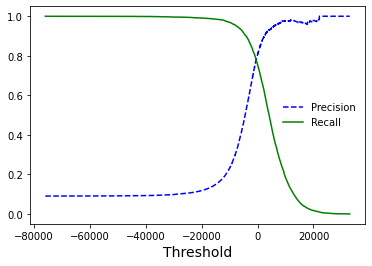

In [25]:
#PLotting to get a "feel" of how precisions and recall vary with a given threshold
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)

In [26]:
plt.show()

The ROC (receiver operating characteristic) curve is another tool commonly used with binary classificators. It plots *true positive rate* (another name for recall) versus the *false positive rate* (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1-*true negative rate*(TNR), which in turn is the ratio of negative instances that are correctly judged as such. The TNR is also called *specificity*.

In [27]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

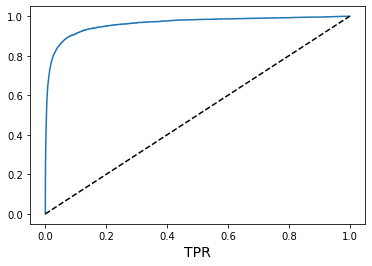

In [28]:
plot_roc_curve(fpr, tpr)

Due to the way that RandomForest works, there is no 'decision_function'. What RF outputs is a *predict_proba* method (Scikit-learn classifiers have either or both). The predict_proba is a matrix where each row is a instance and each column is a class, the entry **a_ij** is the probability that the instance 'i' belongs to class 'j'

In [29]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [30]:
y_scores_forest = y_probas_forest[:, 1] #the second column is the positive case
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

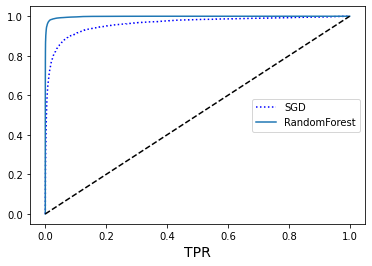

In [31]:
plt.plot(fpr,tpr,"b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="RandomForest")
plt.legend(loc="center right")
plt.show()

As we can see, the root tilts up-left with the Random Forest algorithm, thus it is a good indicator that it has performed better...

In [32]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)


SVC()

In [33]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [35]:
some_digit_scores #Notice that the highest possible value is the 6th: 9.31 (representing the digit 5)

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)


In [37]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [38]:
print(conf_mx)

[[5619    0   19   38    6   25   67    2  129   18]
 [   2 6331   35   78    3   28   20   13  214   18]
 [  46   61 4686  434   56   26  162   61  396   30]
 [  19   17  104 5371    9  200   26   48  257   80]
 [  22   14   28   34 4842   56  104   15  217  510]
 [  59   16   38  449   57 3880  182   20  588  132]
 [  38    7   72   10   29   57 5602    0  101    2]
 [  25   13   51   72   59   28    7 5470  102  438]
 [  37   62   77  254   20  133   59    8 5050  151]
 [  24   18   15  111   83   86    5  127  141 5339]]


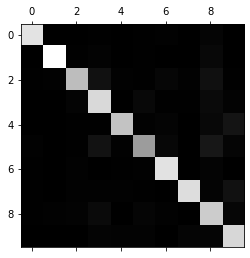

In [39]:
#Showing the confusion as a "heat map".
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

To get a better feeling of the model's prediction, it is better to normalize each row to get recalls and  false negatives for each instance (rows):

In [40]:


row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_mx/row_sums

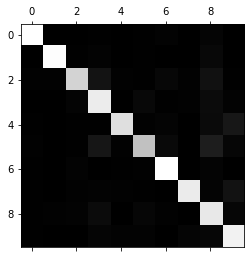

In [41]:
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

As we can see the detection of 8's has low precision (too much false positives), interesting enough is that
 the row corresponding to 8 is dark except its diagonal (conf_mx_8_8). Therefore it has good recall for 8.



If we want multilabel classification, such as whether each train input is odd *and* larger than a number, then KNeighors is a good idea:

In [42]:
y_train_large = (y_train >= 8)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [43]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [44]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [45]:
#generating noisy images and making the test set the original images
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_noisy = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_noisy = X_test + noise
y_train_noisy = X_train
y_test_noisy = X_test


In [46]:
some_noisy_digit = X_train_noisy[0] 
some_noisy_digit_image = some_noisy_digit.reshape(28,28)

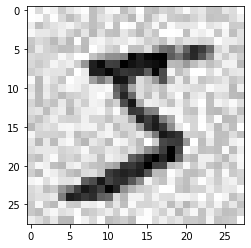

In [47]:
plt.imshow(some_noisy_digit_image, cmap='binary')


In [48]:
knn_clf.fit(X_train_noisy, y_train_noisy)

KNeighborsClassifier()

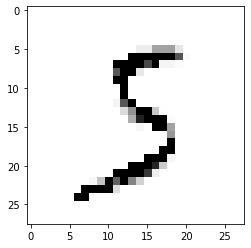

In [49]:
clean_digit = knn_clf.predict([some_noisy_digit])
clean_digit_image = clean_digit.reshape(28,28)
plt.imshow(clean_digit_image, cmap='binary')
